In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize, interpolate

from lmfit import Model


SMALL_SIZE = 22
MEDIUM_SIZE = 24
BIGGER_SIZE = 26

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


### Function definitions

In [2]:
def standardize_within_conditions(df):
    """
    Find linear transformation that lines up data from manual and automatic
    tiration runs to allow a global fit to all data. 
    """
    
    # Model for linear transformation of datasets
    def _line(x,m,b):
        return m*x+b
    
    # Work on a copy
    df = df.copy()
    
    # New columns we're going to populate
    df["include_in_fit"] = True
    df["reg_signal"] = 0.0
    df["weight"] = 1.0
    df["ffx"] = np.nan
    
    conditions = set(list(zip(df.variant,df.calcium_conc)))
    for c in conditions:
        
        # Get mask to pull out only experiments that match this condition
        mask = np.logical_and(df.variant == c[0],
                              np.isclose(df.calcium_conc,c[1]))
        
        # Get matching experiments
        experiments = df.loc[mask,:]
        
        # Get the manual experiment that hits the highest urea concentration
        # as our reference experiment.
        manual = experiments.loc[experiments.expt_type == "manual",:]
        ref_biorep = manual.biorep.iloc[np.argmax(manual.urea)]
        ref_expt = experiments.loc[experiments.biorep == ref_biorep,:]
        
        # Go over all bioreps
        all_bioreps = np.unique(experiments.biorep)
        for i in all_bioreps:
            
            # Get this biorep
            this_expt = experiments.loc[experiments.biorep == i,:]
            
            # Mask that points to this bio rep
            biorep_mask = np.logical_and(mask,df.biorep == i)
            
            # Assign a weight of 1/num_points to this biorep to appropriately
            # weight between experiments during global fit. This makes sure the
            # automatic titrations -- which have a ton of points -- don't 
            # dominate the regression.
            df.loc[biorep_mask,"weight"] = 1/len(this_expt)
            
            # Don't rescale ref -- we're rescaling to it
            if i == ref_biorep:
                df.loc[biorep_mask,"reg_signal"] = this_expt.cd_signal
                continue
            
            # Figure out which dataset we're having to interpolate. Either this
            # experiment or the reference. 
            if np.max(this_expt.urea) < np.max(ref_expt.urea):
                
                # Generate interpolator and urea values to use inside the
                # interpolator. (Interpolate ref_expt)
                f = interpolate.interp1d(ref_expt.urea, ref_expt.cd_signal,
                                         kind='cubic',fill_value="extrapolate")
                                
                # Fit a line between the interpolated ref_expt and experiment
                popt, pcov = optimize.curve_fit(_line,
                                                f(this_expt.urea),
                                                this_expt.cd_signal,
                                                p0=[1, -1600000])
                
                # Transform this_expt signal to match the ref_expt
                new_y = this_expt.cd_signal/popt[0] - popt[1]
                
            else:
                
                # Generate interpolator and urea values to use inside the
                # interpolator. (Interpolate this_expt)
                f = interpolate.interp1d(this_expt.urea, this_expt.cd_signal,
                                         kind='cubic',fill_value="extrapolate")
                
                popt, pcov = optimize.curve_fit(_line,
                                                f(ref_expt.urea),
                                                ref_expt.cd_signal,
                                                p0=[1, -1600000])
                
                new_y = this_expt.cd_signal*popt[0] + popt[1]
                                
            # Put transformed cd_signal into "signal" column for this biorep            
            df.loc[biorep_mask,"reg_signal"] = new_y
            
        
        ignore_mask = np.logical_and(mask,np.isclose(df.urea,0))
        df.loc[ignore_mask,"include_in_fit"] = False
                
        norm_mask = np.logical_and(mask,df.include_in_fit)
        norm_sig = df.loc[norm_mask,"reg_signal"]
                            
        a = np.min(norm_sig)
        b = np.max(norm_sig)

        df.loc[mask,"ffx"] = 1 - (df.loc[mask,"reg_signal"] - a)/(b - a)
    
    
    columns = ['variant','calcium_conc','biorep','expt_type',
               'urea','ffx','weight','include_in_fit','reg_signal','cd_signal',
               'date','file','prot_conc','temp']
    
    return df.loc[:,columns]

def fit_melt(df,variant,calcium_conc,
             m_value=None,fig=None,ax=None,
             gen_plot=True,color="black"):
    """
    Fit chemical denaturation data for a given variant and calcium condition.
    
    df: data frame with regularized values
    variant: protein variant (string)
    calicum_conc: calcium_conc
    m_value: m-value to use. if None, float
    fig, ax: matplotlib objects to use for fit. if None, create
    gen_plot: generate a plot
    color: color for points/fit
    """
    
    def _melt(urea, nat_b, nat_m, den_b, den_m, dG, m_value):
        
        native = nat_b + nat_m*urea
        denat = den_b + den_m*urea
        K = np.exp(-(dG - m_value*urea)/(0.001987*298.15))
        
        return native + denat*K/(1+K)
    
    # Extract data to fit
    mask = np.logical_and(df.variant == variant,
                          df.calcium_conc == calcium_conc)
    df = df.loc[np.logical_and(mask,df.include_in_fit),:]
    
    # Decide whether or not to vary m-value based on whether a value is 
    # specified as an argument. 
    if m_value is None:
        m_value = 1
        vary_m_value = True
    else:
        vary_m_value = False
    
    # Set up fit object
    melt_model = Model(_melt)
    params = melt_model.make_params(m_value=m_value, nat_b=1, nat_m=0, den_b=0, den_m=0, dG=5)

    # Float/do not float m value
    params["m_value"].vary = vary_m_value
    params["nat_m"].min = -0.08
    params["nat_m"].max = 0.08

    # Do fit
    fit = melt_model.fit(df.ffx, params, urea=df.urea, weights=df.weight) 

    # calculate rmsd for fit
    rmsd = np.sqrt(np.sum(fit.residual**2)/fit.ndata)
    
    # dG
    dG = fit.values["dG"]
    
    # dG error
    if fit.covar is None:
        dG_err = np.nan
    else:
        dG_index = list(fit.params.keys()).index("dG")
        dG_err = fit.covar[dG_index][dG_index]

    if vary_m_value:
        
        # m value
        m = fit.values["m_value"]

        # m-value error
        if fit.covar is None:
            m_err = np.nan
        else:
            m_index = list(fit.params.keys()).index("m_value")
            m_err = fit.covar[m_index][m_index]
            
    else:
        m = m_value
        m_err = 0.2
        
    # Cm
    Cm = dG/m
    Cm_err = np.abs(Cm)*np.sqrt((m_err/m)**2 + (dG_err/dG)**2)

    # Create human-readable output
    summary_data = pd.DataFrame({"variant":[variant],
                                 "calcium_conc":[calcium_conc],
                                 "dG":[dG],
                                 "dG_err":[dG_err],
                                 "m":[m],
                                 "m_err":[m_err],
                                 "Cm":[Cm],
                                 "Cm_err":[Cm_err],
                                 "rmsd":[rmsd]})

    if gen_plot:
        
        if ax is None:
            fig, ax = plt.subplots(1,figsize=(6,6))
    
        for i in np.unique(df.biorep):

            expt = df.loc[df.biorep == i,:]
            
            if expt.expt_type.iloc[0] == "manual":
                point_fmt = {"ms":20,"mfc":"none","mec":color}
            else:
                point_fmt = {"ms":20,"mfc":color,"mec":color}

            ax.plot(expt.urea,expt.ffx,".",**point_fmt)

        urea_span = np.linspace(0,np.max(df.urea)*1.05,100)

        fit_y = _melt(urea_span,
                      fit.values["nat_b"],
                      fit.values["nat_m"],
                      fit.values["den_b"],
                      fit.values["den_m"],
                      fit.values["dG"],
                      fit.values["m_value"])

        ax.plot(urea_span,fit_y,"-",lw=3,color=color)
        
        ax.set_xlabel("[urea] (M)")
        ax.set_ylabel("fraction signal")
    
    return summary_data, fig, ax


def fit_all_melts(df,m_value=None):
    
    # Fit hS100A9
    s1, fig, ax = fit_melt(df,"hS100A9",0,m_value=m_value,color="black")
    s2, _, _ = fit_melt(df,"hS100A9",0.0005,m_value=m_value,fig=fig,ax=ax,color="darkgreen")
    s3, _, _ = fit_melt(df,"hS100A9",0.005,m_value=m_value,fig=fig,ax=ax,color="yellowgreen")
    ax.set_title("hS100A9")
    wt = pd.concat([s1,s2,s3])

    # Fit hS100A9/M63F
    s1, fig, ax = fit_melt(df,"hS100A9/M63F",0,m_value=m_value,color="black")
    s2, _, _ = fit_melt(df,"hS100A9/M63F",0.0005,m_value=m_value,fig=fig,ax=ax,color="darkgreen")
    s3, _, _ = fit_melt(df,"hS100A9/M63F",0.005,m_value=m_value,fig=fig,ax=ax,color="yellowgreen")
    ax.set_title("hS100A9/M63F")
    m63f = pd.concat([s1,s2,s3])

    # Fit hS100A9/F37L
    s1, fig, ax = fit_melt(df,"hS100A9/F37L",0,m_value=m_value,color="black")
    s2, _, _ = fit_melt(df,"hS100A9/F37L",0.0005,m_value=m_value,fig=fig,ax=ax,color="darkgreen")
    s3, _, _ = fit_melt(df,"hS100A9/F37L",0.005,m_value=m_value,fig=fig,ax=ax,color="yellowgreen")
    ax.set_title("hS100A9/F37L")
    f37l = pd.concat([s1,s2,s3])

    # Fit hS100A9/F37L/M63F
    s1, fig, ax = fit_melt(df,"hS100A9/F37L/M63F",0,m_value=m_value,color="black")
    s2, _, _ = fit_melt(df,"hS100A9/F37L/M63F",0.0005,m_value=m_value,fig=fig,ax=ax,color="darkgreen")
    s3, _, _ = fit_melt(df,"hS100A9/F37L/M63F",0.005,m_value=m_value,fig=fig,ax=ax,color="yellowgreen")
    ax.set_title("hS100A9/F37L/M63F")
    double = pd.concat([s1,s2,s3])

    # Record final results, setting error to 0.5 if less than that
    result_df = pd.concat([wt,m63f,f37l,double])
    result_df.loc[result_df.dG_err < 0.5,"dG_err"] = 0.5
    
    return result_df


def print_mutant_cycle(result_df,calcium_concs=[0,0.005]):
    """
    Print a mutant cycle given a result data frame with four protein dG values.
    
    result_df: dataframe with mutant data
    calcium_concs: calcium concentrations at which to do calculation
    """

    for conc in calcium_concs:

        hA9 = result_df.loc[np.logical_and(result_df.variant=="hS100A9",
                                           np.isclose(result_df.calcium_conc,conc)),:]
        f37l = result_df.loc[np.logical_and(result_df.variant=="hS100A9/F37L",
                                            np.isclose(result_df.calcium_conc,conc)),:]
        m63f = result_df.loc[np.logical_and(result_df.variant=="hS100A9/M63F",
                                            np.isclose(result_df.calcium_conc,conc)),:]
        double = result_df.loc[np.logical_and(result_df.variant=="hS100A9/F37L/M63F",
                                              np.isclose(result_df.calcium_conc,conc)),:]

        print(f"L/M ({float(f37l.dG):.1f} +/- {float(f37l.dG_err):.1f}) -> L/F ({float(double.dG):.1f} +/- {float(double.dG_err):.1f})")
        print(10*" ","|",19*" ","|")
        print(10*" ","|",19*" ","|")
        print(f"F/M ({float(hA9.dG):.1f} +/- {float(hA9.dG_err):.1f}) -> F/F ({float(m63f.dG):.1f} +/- {float(m63f.dG_err):.1f})")
        print()

        print("single effects")
        effect = float(hA9.dG - f37l.dG) # F/M - L/M
        err = float(np.sqrt(hA9.dG_err**2 + f37l.dG_err**2))
        print(f"L37F effect: {effect:.1f} +/- {err:.1f}")

        effect = float(double.dG - f37l.dG) # L/F - L/M
        err = float(np.sqrt(double.dG_err**2 + f37l.dG_err**2))
        print(f"M63F effect: {effect:.1f} +/- {err:.1f}")
        print()

        print("coupled effects")
        effect = float(m63f.dG - double.dG) # F/F - L/F
        err = float(np.sqrt(hA9.dG_err**2 + f37l.dG_err**2))
        print(f"L37F effect: {effect:.1f} +/- {err:.1f}")

        effect = float(m63f.dG - hA9.dG) # F/F - F/M
        err = float(np.sqrt(double.dG_err**2 + f37l.dG_err**2))
        print(f"M63F effect: {effect:.1f} +/- {err:.1f}")
        print()

        # (F/F - L/F) - (F/M - L/M)
        coupling = float((m63f.dG - double.dG) - (hA9.dG - f37l.dG))
        coupling_err = float(np.sqrt(np.sum(np.array([m63f.dG_err,double.dG_err,hA9.dG_err,f37l.dG_err])**2)))

        print(f"F/F coupling at {conc:.3f} M calcium: {coupling:.1f} +/- {coupling_err:.1f}")
        print()

        print("---")

### Read raw data and regularize

In [3]:
raw_df = pd.read_csv("raw-melt-data.csv")
df = standardize_within_conditions(raw_df)

/Users/harmsm/miniconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


## Fit all data, floating m value

## Table S2

,variant,calcium_conc,dG,dG_err,m,m_err,Cm,Cm_err,rmsd
0,hS100A9,0.0000,2.889849,0.500000,1.026302,0.005160,2.815787,0.081533,0.000596
0,hS100A9,0.0005,2.356891,0.500000,0.693872,0.011090,3.396723,0.368908,0.001902
0,hS100A9,0.0050,5.241224,1.358527,1.159114,0.061187,4.521750,1.196098,0.002748
0,hS100A9/M63F,0.0000,2.889842,0.500000,1.072824,0.006568,2.693677,0.093241,0.001012
0,hS100A9/M63F,0.0005,7.161738,0.500000,1.388773,0.005948,5.156881,0.116273,0.000978
0,hS100A9/M63F,0.0050,10.787518,1.693703,1.532599,0.039154,7.038709,1.119653,0.001831
0,hS100A9/F37L,0.0000,2.712817,0.500000,0.897177,0.010496,3.023726,0.227125,0.001314
0,hS100A9/F37L,0.0005,1.904685,0.955856,0.665869,0.037847,2.860452,1.444680,0.004017
0,hS100A9/F37L,0.0050,2.114804,0.500000,0.654092,0.014669,3.233193,0.499379,0.002702
0,hS100A9/F37L/M63F,0.0000,3.633885,0.500000,1.136119,0.023631,3.198508,0.340792,0.001460


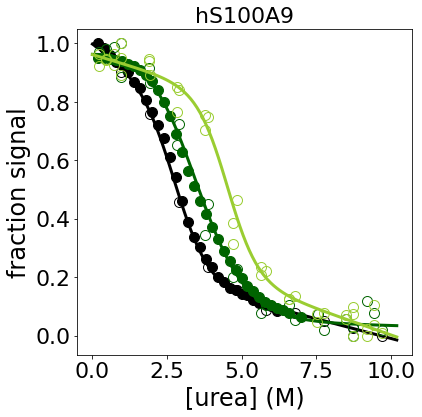

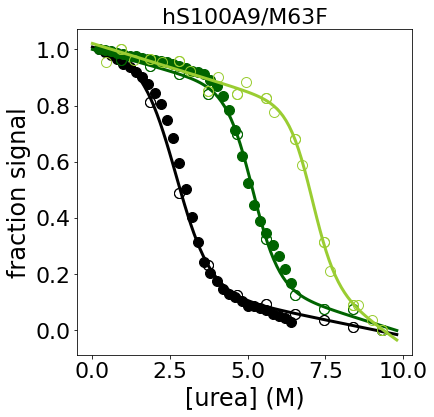

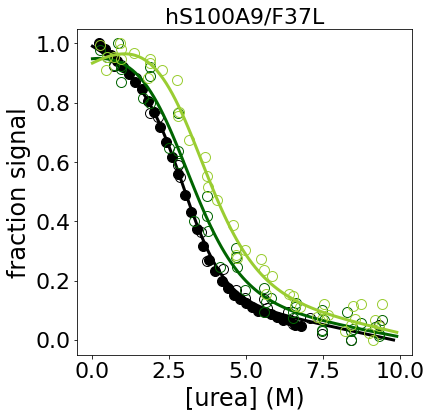

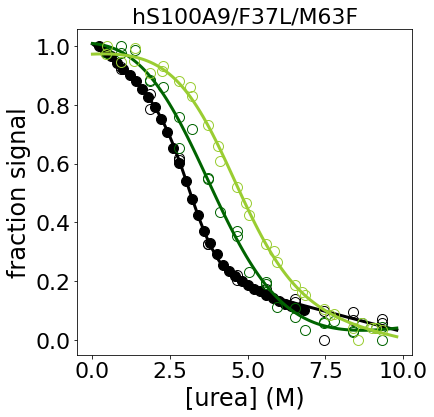

In [4]:
result_df = fit_all_melts(df)
result_df.to_csv("table_s2.csv")
result_df

## Find global m-value and fit all data using that m-value

## Fig S1A, Table S1

,variant,calcium_conc,dG,dG_err,m,m_err,Cm,Cm_err,rmsd
0,hS100A9,0.0000,2.600859,0.5,0.95,0.2,2.737746,0.576394,0.000606
0,hS100A9,0.0005,3.456928,0.5,0.95,0.2,3.638871,0.766266,0.001979
0,hS100A9,0.0050,4.286158,0.5,0.95,0.2,4.511746,0.950171,0.002772
0,hS100A9/M63F,0.0000,2.416802,0.5,0.95,0.2,2.544002,0.535622,0.001041
0,hS100A9/M63F,0.0005,4.908849,0.5,0.95,0.2,5.167210,1.087841,0.001381
0,hS100A9/M63F,0.0050,7.006999,0.5,0.95,0.2,7.375788,1.553044,0.002336
0,hS100A9/F37L,0.0000,2.929658,0.5,0.95,0.2,3.083850,0.649380,0.001316
0,hS100A9/F37L,0.0005,3.088715,0.5,0.95,0.2,3.251278,0.688691,0.004099
0,hS100A9/F37L,0.0050,3.364329,0.5,0.95,0.2,3.541399,0.745874,0.002815
0,hS100A9/F37L/M63F,0.0000,2.918976,0.5,0.95,0.2,3.072606,0.647175,0.001481


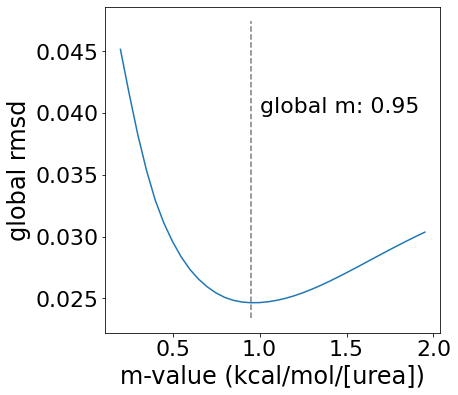

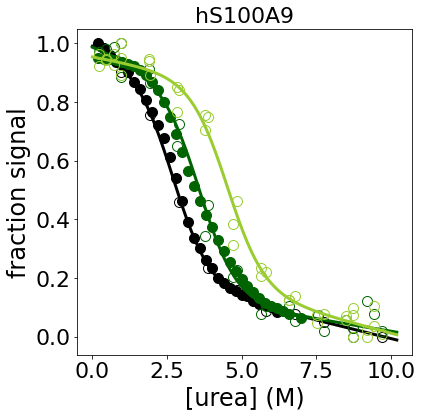

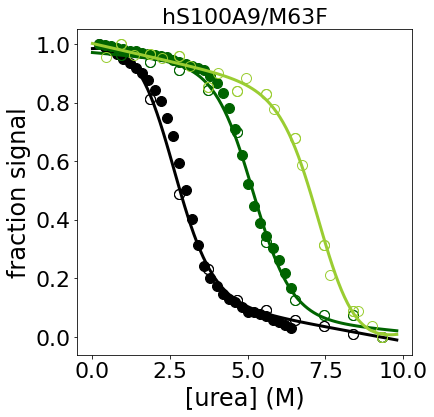

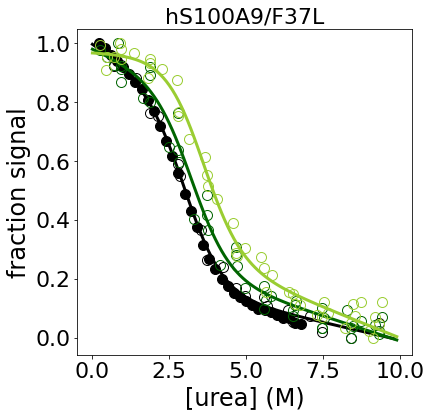

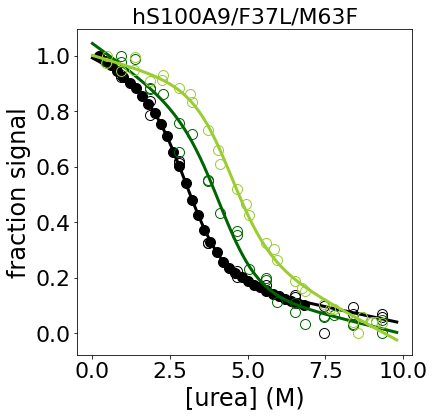

In [5]:
m_values = np.arange(0.2,2.0,0.05)
rmsd = []
for m in m_values:
    rmsd.append(0)
    for v in np.unique(df.variant):
        for c in np.unique(df.calcium_conc):
            d = fit_melt(df,v,c,m_value=m,gen_plot=False)
            rmsd[-1] += d[0].rmsd.iloc[0]


fig, ax = plt.subplots(1,figsize=(6,6))
ax.plot(m_values,rmsd)
ax.set_xlabel("m-value (kcal/mol/[urea])")
ax.set_ylabel("global rmsd")

min_rmsd_index = np.argmin(rmsd)
global_m = m_values[min_rmsd_index]
ax.plot((global_m,global_m),(np.min(rmsd)*0.95,np.max(rmsd)*1.05),'--',color='gray')
ax.text(1,0.04,f"global m: {global_m:.2f}")
fig.savefig("figure-s1a.pdf")

result_df_fixed_m = fit_all_melts(df,m_value=global_m)
result_df_fixed_m.to_csv("table_s1.csv")
result_df_fixed_m

## Figure 2B, C

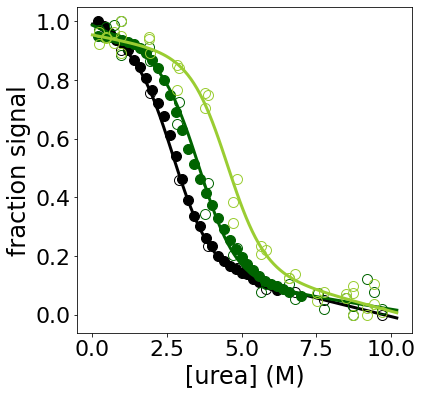

In [6]:
s1, fig, ax = fit_melt(df,"hS100A9",0,m_value=global_m,color="black")
s1, fig, ax = fit_melt(df,"hS100A9",0.0005,m_value=global_m,color="darkgreen",fig=fig,ax=ax)
s1, fig, ax = fit_melt(df,"hS100A9",0.005,m_value=global_m,color="yellowgreen",fig=fig,ax=ax)
plt.savefig("figure-2b.pdf")

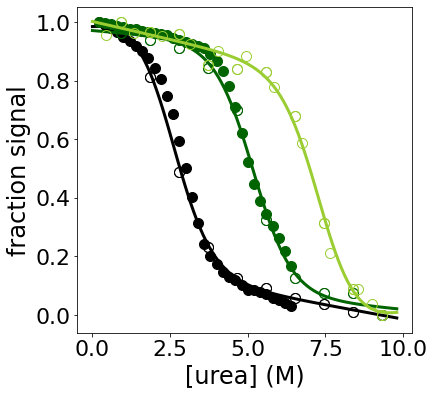

In [7]:
s1, fig, ax = fit_melt(df,"hS100A9/M63F",0,m_value=global_m,color="black")
s1, fig, ax = fit_melt(df,"hS100A9/M63F",0.0005,m_value=global_m,color="darkgreen",fig=fig,ax=ax)
s1, fig, ax = fit_melt(df,"hS100A9/M63F",0.005,m_value=global_m,color="yellowgreen",fig=fig,ax=ax)
plt.savefig("figure-2c.pdf")

### Fig 5A (Phe/Phe mutant cycle, 0 mM Ca2+)

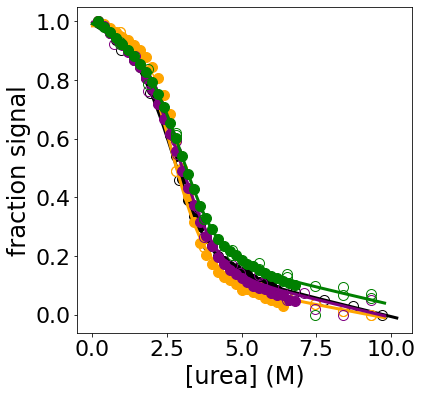

In [8]:
s1, fig, ax = fit_melt(df,"hS100A9",0,m_value=global_m,color="black")
s1, fig, ax = fit_melt(df,"hS100A9/M63F",0,m_value=global_m,color="orange",fig=fig,ax=ax)
s1, fig, ax = fit_melt(df,"hS100A9/F37L",0,m_value=global_m,color="purple",fig=fig,ax=ax)
s1, fig, ax = fit_melt(df,"hS100A9/F37L/M63F",0,m_value=global_m,color="green",fig=fig,ax=ax)
plt.savefig("figure-5a.pdf")

### Fig 5B (Phe/Phe mutant cycle, 5 mM Ca2+)

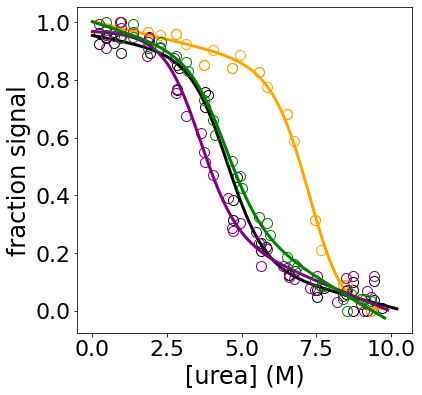

In [9]:
m_value=None
s1, fig, ax = fit_melt(df,"hS100A9",0.005,m_value=global_m,color="black")
s1, fig, ax = fit_melt(df,"hS100A9/M63F",0.005,m_value=global_m,color="orange",fig=fig,ax=ax)
s1, fig, ax = fit_melt(df,"hS100A9/F37L",0.005,m_value=global_m,color="purple",fig=fig,ax=ax)
s1, fig, ax = fit_melt(df,"hS100A9/F37L/M63F",0.005,m_value=global_m,color="green",fig=fig,ax=ax)
plt.savefig("figure-5b.pdf")

## Mutant cycle
## Fig S6 (top)

In [10]:
print_mutant_cycle(result_df,calcium_concs=[0,0.005])

L/M (2.7 +/- 0.5) -> L/F (3.6 +/- 0.5)
           |                     |
           |                     |
F/M (2.9 +/- 0.5) -> F/F (2.9 +/- 0.5)

single effects
L37F effect: 0.2 +/- 0.7
M63F effect: 0.9 +/- 0.7

coupled effects
L37F effect: -0.7 +/- 0.7
M63F effect: -0.0 +/- 0.7

F/F coupling at 0.000 M calcium: -0.9 +/- 1.0

---
L/M (2.1 +/- 0.5) -> L/F (2.5 +/- 0.5)
           |                     |
           |                     |
F/M (5.2 +/- 1.4) -> F/F (10.8 +/- 1.7)

single effects
L37F effect: 3.1 +/- 1.4
M63F effect: 0.4 +/- 0.7

coupled effects
L37F effect: 8.3 +/- 1.4
M63F effect: 5.5 +/- 0.7

F/F coupling at 0.005 M calcium: 5.1 +/- 2.3

---


## Fig 5AB, Fig S6 (bottom)

In [11]:
print_mutant_cycle(result_df_fixed_m,calcium_concs=[0,0.005])

L/M (2.9 +/- 0.5) -> L/F (2.9 +/- 0.5)
           |                     |
           |                     |
F/M (2.6 +/- 0.5) -> F/F (2.4 +/- 0.5)

single effects
L37F effect: -0.3 +/- 0.7
M63F effect: -0.0 +/- 0.7

coupled effects
L37F effect: -0.5 +/- 0.7
M63F effect: -0.2 +/- 0.7

F/F coupling at 0.000 M calcium: -0.2 +/- 1.0

---
L/M (3.4 +/- 0.5) -> L/F (4.2 +/- 0.5)
           |                     |
           |                     |
F/M (4.3 +/- 0.5) -> F/F (7.0 +/- 0.5)

single effects
L37F effect: 0.9 +/- 0.7
M63F effect: 0.8 +/- 0.7

coupled effects
L37F effect: 2.8 +/- 0.7
M63F effect: 2.7 +/- 0.7

F/F coupling at 0.005 M calcium: 1.9 +/- 1.0

---


## Plot fits with floating m-values

## Figure S1B,C

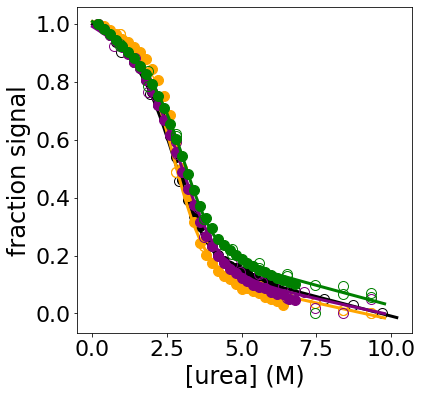

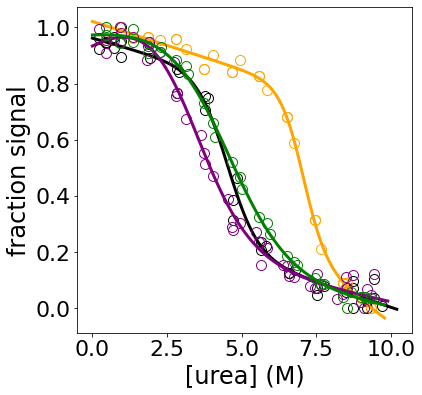

In [12]:
s1, fig, ax = fit_melt(df,"hS100A9",0,m_value=None,color="black")
s1, fig, ax = fit_melt(df,"hS100A9/M63F",0,m_value=None,color="orange",fig=fig,ax=ax)
s1, fig, ax = fit_melt(df,"hS100A9/F37L",0,m_value=None,color="purple",fig=fig,ax=ax)
s1, fig, ax = fit_melt(df,"hS100A9/F37L/M63F",0,m_value=None,color="green",fig=fig,ax=ax)
plt.savefig("figure-s1b.pdf")

s1, fig, ax = fit_melt(df,"hS100A9",0.005,m_value=None,color="black")
s1, fig, ax = fit_melt(df,"hS100A9/M63F",0.005,m_value=None,color="orange",fig=fig,ax=ax)
s1, fig, ax = fit_melt(df,"hS100A9/F37L",0.005,m_value=None,color="purple",fig=fig,ax=ax)
s1, fig, ax = fit_melt(df,"hS100A9/F37L/M63F",0.005,m_value=None,color="green",fig=fig,ax=ax)
plt.savefig("figure-s1c.pdf")

## Compare the floating vs. fixed m-value results

## Fig S1DEF


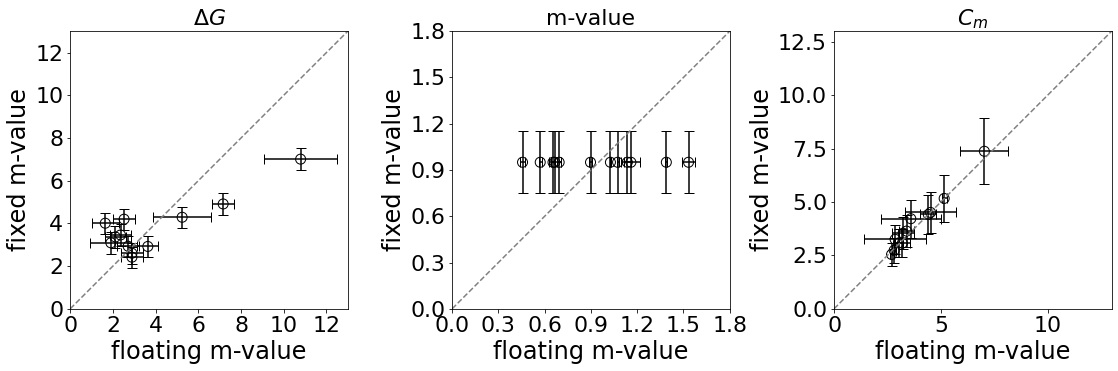

In [13]:
fig, ax = plt.subplots(1,3,figsize=(16,8))

ax[0].errorbar(result_df.dG,
            result_df_fixed_m.dG,
            xerr=result_df.dG_err,
            yerr=result_df_fixed_m.dG_err,
            fmt='none',capsize=5,color='black')
ax[0].scatter(result_df.dG,result_df_fixed_m.dG,s=100,edgecolor='black',facecolor='none')

ax[0].plot((0,13),(0,13),'--',color='gray')

ax[0].set_xlim((0,13))
ax[0].set_ylim((0,13))
ax[0].set_xticks((0,2,4,6,8,10,12))
ax[0].set_yticks((0,2,4,6,8,10,12))

ax[0].set_aspect('equal', adjustable='box')
ax[0].set_xlabel("floating m-value")
ax[0].set_ylabel("fixed m-value")
ax[0].set_title("$\Delta G$")

ax[1].errorbar(result_df.m,
            result_df_fixed_m.m,
            xerr=result_df.m_err,
            yerr=result_df_fixed_m.m_err,
            fmt='none',capsize=5,color='black')
ax[1].scatter(result_df.m,result_df_fixed_m.m,s=100,edgecolor='black',facecolor='none')

ax[1].plot((0,1.8),(0,1.8),'--',color='gray')

ax[1].set_xlim((0,1.8))
ax[1].set_ylim((0,1.8))
ax[1].set_xticks((0,0.3,0.6,0.9,1.2,1.5,1.8))
ax[1].set_yticks((0,0.3,0.6,0.9,1.2,1.5,1.8))

ax[1].set_aspect('equal', adjustable='box')
ax[1].set_xlabel("floating m-value")
ax[1].set_ylabel("fixed m-value")
ax[1].set_title("m-value")

ax[2].errorbar(result_df.Cm,
            result_df_fixed_m.Cm,
            xerr=result_df.Cm_err,
            yerr=result_df_fixed_m.Cm_err,
            fmt='none',capsize=5,color='black')
ax[2].scatter(result_df.Cm,result_df_fixed_m.Cm,s=100,edgecolor='black',facecolor='none')
ax[2].plot((0,13),(0,13),'--',color='gray')

ax[2].set_xlim((0,13))
ax[2].set_ylim((0,13))

ax[2].set_aspect('equal', adjustable='box')
ax[2].set_xlabel("floating m-value")
ax[2].set_ylabel("fixed m-value")
ax[2].set_title("$C_{m}$")

ax[2].set_aspect('equal', adjustable='box')

fig.tight_layout()

fig.savefig("figure-s1def.pdf")

## AIC test favors the fixed m-value

For floating m-values, there are 73 total fit parameters: $1 + 12 \times 6$ for the residual and 12 datasets with 6 parameters each.

For the fixed m-value, there are 62 total fit parameters: $1 + 12 \times 5 + 1$ for the residual, 12 datasets with 5 parameters each, and the globally fit m-value. 

We can calculate the log likelihood according to:

$$lnL = -0.5 \times \Big ( \frac{RMSD}{\sigma^{2}} \Big ) - 0.5 \times ln(\sigma^{2}) $$

Based on the scatter in the points, we estimate $\sigma = 0.05$. 

$$AIC \equiv 2k - 2lnL$$


In [14]:
sigma2 = 0.05**2

float_rmsd = np.sum(result_df.rmsd)
float_k = 1 + 12*5 + 12
float_lnL = -0.5*(float_rmsd/sigma2 + np.log(sigma2))
float_AIC = 2*float_k - 2*float_lnL
print("AIC float:",float_AIC)


fixed_rmsd = np.sum(result_df_fixed_m.rmsd)
fixed_k = 1 + 12*5 + 1
fixed_lnL = -0.5*(fixed_rmsd/sigma2 + np.log(sigma2))
fixed_AIC = 2*fixed_k - 2*fixed_lnL
print("AIC fixed:",fixed_AIC)

# Float AIC weight
x = np.exp((fixed_AIC - float_AIC)/2)

# Float AIC probability
x/(1 + x)



AIC float: 149.06127904332638
AIC fixed: 127.87061509526815


2.5031963585768005e-05